# Prepare seu dataset para modelagem de dados

In [ ]:
!pip install pydantic_settings
!pip install sidetable

## Imports

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from pydantic_settings import BaseSettings

import sidetable
import missingno as msno
from ipywidgets import interact, widgets

from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform


## Base de Dados

### Importando o dataset

In [ ]:
dadosBase = pd.read_csv("data.csv", sep=',', encoding='latin1')

### Compreendendo os dados

In [ ]:
dadosBase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
dadosBase.drop(columns=['CustomerID']).describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


## Tratamento da Base de Dados

### Valores faltante na identificação do cliente

In [ ]:
# Identificar e mostrar valores nulos
df_missing = (
  dadosBase.isna().sum()
  .to_frame('qtd_dadosfaltantes')
  .join((dadosBase.isna().sum() / dadosBase.shape[0]).to_frame('percentagem_dadosfaltantes'))
  .sort_values('qtd_dadosfaltantes', ascending=False)
)

df_missing.style.format('{:.2%}', subset=['percentagem_dadosfaltantes'])

,qtd_dadosfaltantes,percentagem_dadosfaltantes
CustomerID,135080,24.93%
Description,1454,0.27%
InvoiceNo,0,0.00%
StockCode,0,0.00%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
Country,0,0.00%


In [ ]:
dadosBase.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


<Axes: >

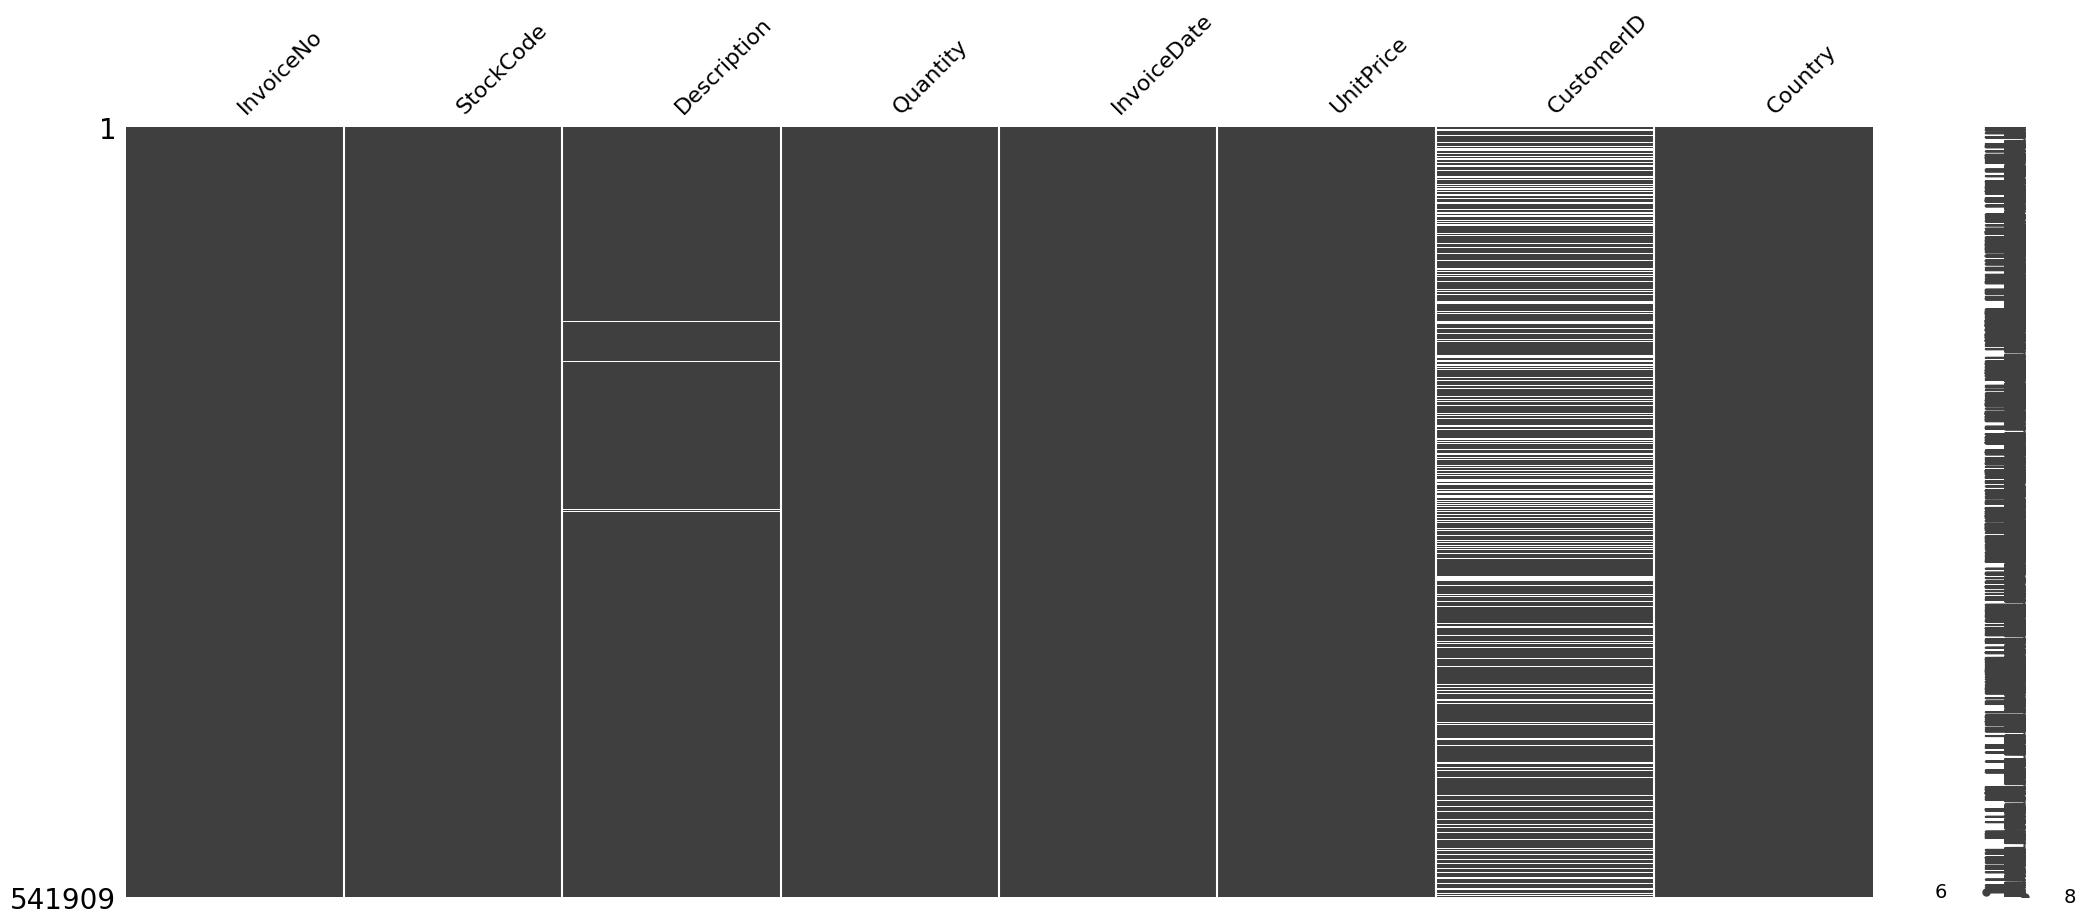

In [ ]:
msno.matrix(dadosBase)

In [ ]:
dB_withoutNulls_CustomerID = dadosBase.dropna(subset=['CustomerID']).copy()

In [ ]:
dB_withoutNulls_CustomerID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [ ]:
dB_withoutNulls_CustomerID.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


### Preços unitários e quantidade de produtos iguais ou inferior a 0

In [ ]:
dB_withoutNulls = dB_withoutNulls_CustomerID.copy()

In [ ]:
# Função para limpar valores nulos e menores que zero
def clean_dataframe(df, column):
    null_values = df[column].isnull().any()
    zero_values = (df[column] <= 0).any()

    if null_values:
        print(f"A coluna {column} possui valores nulos.")
        df = df.dropna(subset=[column])
    else:
        print(f"A coluna {column} não possui valores nulos.")

    if zero_values:
        print(f"A coluna {column} possui valores menores ou iguais a zero.")
        df = df[df[column] > 0]

    return df

# Supondo que você tenha o DataFrame dB_withougNulls já carregado

# Limpar coluna 'UnitPrice'
dB_cleaned_UnitPrice = clean_dataframe(dB_withoutNulls, 'UnitPrice')

# Limpar coluna 'Quantity'
dB_cleaned_Quantity = clean_dataframe(dB_cleaned_UnitPrice, 'Quantity')


A coluna UnitPrice não possui valores nulos.
A coluna UnitPrice possui valores menores ou iguais a zero.
A coluna Quantity não possui valores nulos.
A coluna Quantity possui valores menores ou iguais a zero.


In [ ]:
dB_cleaned_Quantity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


### Verifique se existem linhas duplicadas


In [ ]:
dB_viewDuplicate = dB_cleaned_Quantity.copy()
dB_withoutDuplicate = dB_viewDuplicate.drop_duplicates().copy()
dB_withoutDuplicate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392692 non-null  object 
 1   StockCode    392692 non-null  object 
 2   Description  392692 non-null  object 
 3   Quantity     392692 non-null  int64  
 4   InvoiceDate  392692 non-null  object 
 5   UnitPrice    392692 non-null  float64
 6   CustomerID   392692 non-null  float64
 7   Country      392692 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


### Tipo de dados da coluna

In [ ]:
dB_typeData = dB_withoutDuplicate.copy()

In [ ]:
dB_typeData['InvoiceDate'] = pd.to_datetime(dB_typeData['InvoiceDate'], format='%m/%d/%Y %H:%M')
dB_typeData['CustomerID'] = dB_typeData['CustomerID'].astype('int64')

In [ ]:
dB_typeData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


### Tratando os outliers

In [ ]:
dB_TreatingOutliers = dB_typeData.copy()

In [ ]:
print(dB_TreatingOutliers.shape)
dB_TreatingOutliers.head(3)

(392692, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom


In [ ]:
dB_TreatingOutliers['CustomerID'] = dB_TreatingOutliers['CustomerID'].astype('str')


def get_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    return numeric_columns

# Uso:
numeric_columns = get_numeric_columns(dB_TreatingOutliers)
print(numeric_columns)

['Quantity', 'UnitPrice']


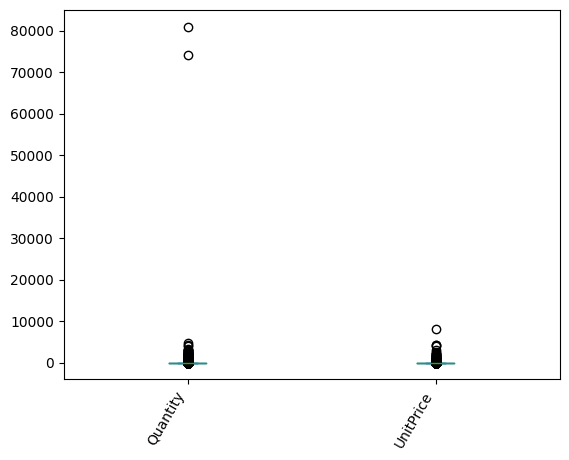

In [ ]:
# Identificando outlier
# Box plot com dados "as is"
dB_TreatingOutliers[numeric_columns].plot.box()
plt.xticks(rotation=60, ha='right');

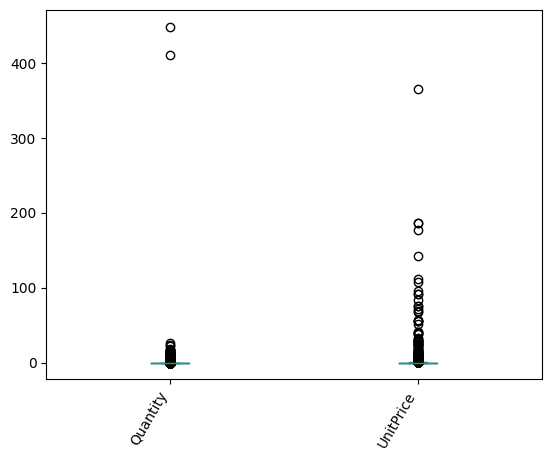

In [ ]:
# Box plot com dados padronizados
dB_TreatingOutliers[numeric_columns].apply(scale).plot.box()
plt.xticks(rotation=60, ha='right');

In [ ]:
dB_TreatingOutliers.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France


In [ ]:
def is_outlier(array, extreme=False):
  """Custom function to identify outliers in an array"""
  q1,q3 = np.quantile(array, [.25,.75])
  iqr = q3-q1

  factor = 3. if extreme else 1.5
  upper_outlier = q3 + factor*iqr
  lower_outlier = q1 - factor*iqr

  return (array < lower_outlier) | (array > upper_outlier)

In [ ]:
# Mostrando aplicação da função para todas colunas numéricas contínuas
dB_TreatingOutliers[numeric_columns].apply(lambda col: is_outlier(col) if np.issubdtype(col.dtype, np.number) else False)


,Quantity,UnitPrice
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
541904,False,False
541905,False,False
541906,False,False
541907,False,False


In [ ]:
# Calculando quantidade de outliers
dB_TreatingOutliers[numeric_columns].apply(lambda col: is_outlier(col) if np.issubdtype(col.dtype, np.number) else False).sum()

Quantity     25616
UnitPrice    34112
dtype: int64

In [ ]:
# Removendo outliers
dB_withoutOutliers = dB_TreatingOutliers[~dB_TreatingOutliers[numeric_columns].apply(is_outlier).any(axis=1)]

In [ ]:
dB_withoutOutliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333234 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    333234 non-null  object        
 1   StockCode    333234 non-null  object        
 2   Description  333234 non-null  object        
 3   Quantity     333234 non-null  int64         
 4   InvoiceDate  333234 non-null  datetime64[ns]
 5   UnitPrice    333234 non-null  float64       
 6   CustomerID   333234 non-null  object        
 7   Country      333234 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 22.9+ MB


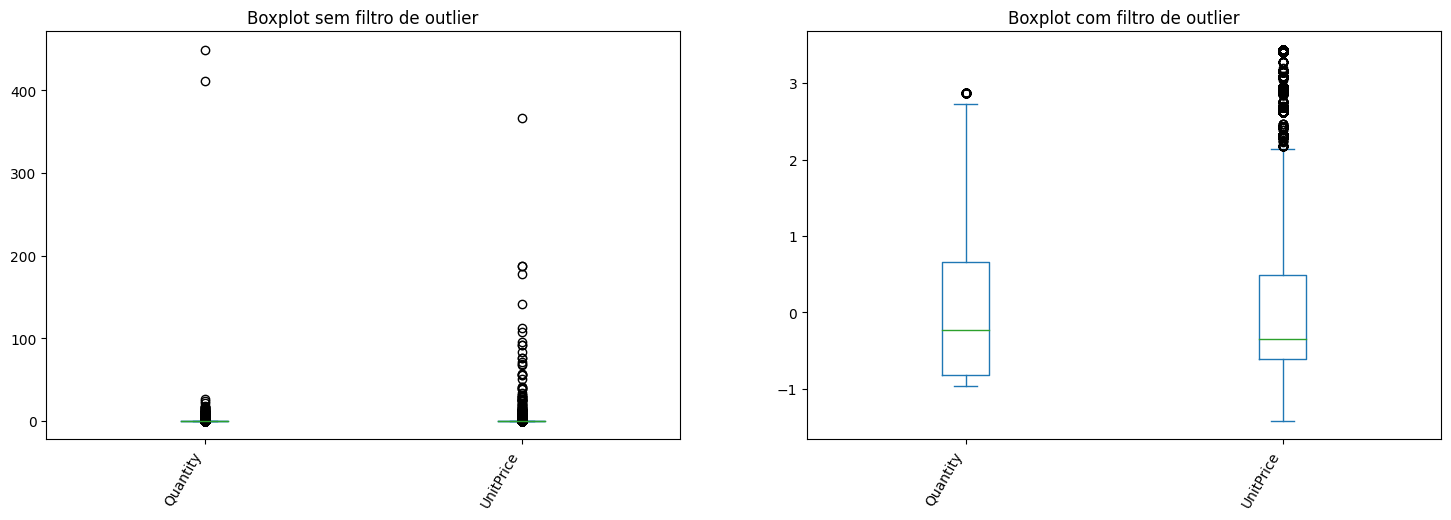

In [ ]:
# Figura lado a lado dos dados originais e padronizados
fig,axes = plt.subplots(ncols=2, figsize=(18,6))

dB_TreatingOutliers[numeric_columns].apply(scale).plot.box(ax=axes[0], title='Boxplot sem filtro de outlier')
dB_withoutOutliers[numeric_columns].apply(scale).plot.box(ax=axes[1], title='Boxplot com filtro de outlier')

fig.autofmt_xdate(rotation=60, ha='right')
plt.show()

In [ ]:
register_outlier = len(dB_withoutOutliers.query('Quantity >= 10000 or UnitPrice >= 5000'))
if register_outlier > 0:
   dB_withoutOutliers = dB_withoutOutliers.query('Quantity <= 10000 or UnitPrice <= 5000').copy()
   print(f"Há {register_outlier} de registros com outliers.")
else:
   dB_withoutOutliers
   print("Sem registros com outliers.")


Sem registros com outliers.


In [ ]:
dB_withoutOutliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333234 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    333234 non-null  object        
 1   StockCode    333234 non-null  object        
 2   Description  333234 non-null  object        
 3   Quantity     333234 non-null  int64         
 4   InvoiceDate  333234 non-null  datetime64[ns]
 5   UnitPrice    333234 non-null  float64       
 6   CustomerID   333234 non-null  object        
 7   Country      333234 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 22.9+ MB


### Coluna Adicional

In [ ]:
df = dB_withoutOutliers.copy()
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [ ]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333234 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    333234 non-null  object        
 1   StockCode    333234 non-null  object        
 2   Description  333234 non-null  object        
 3   Quantity     333234 non-null  int64         
 4   InvoiceDate  333234 non-null  datetime64[ns]
 5   UnitPrice    333234 non-null  float64       
 6   CustomerID   333234 non-null  object        
 7   Country      333234 non-null  object        
 8   TotalPrice   333234 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 25.4+ MB


## Ultima data


In [ ]:
last_date = df['InvoiceDate'].max()

print(last_date)

2011-12-09 12:50:00


## Análise Gráfica

### Top 10 países com maior valor em vendas

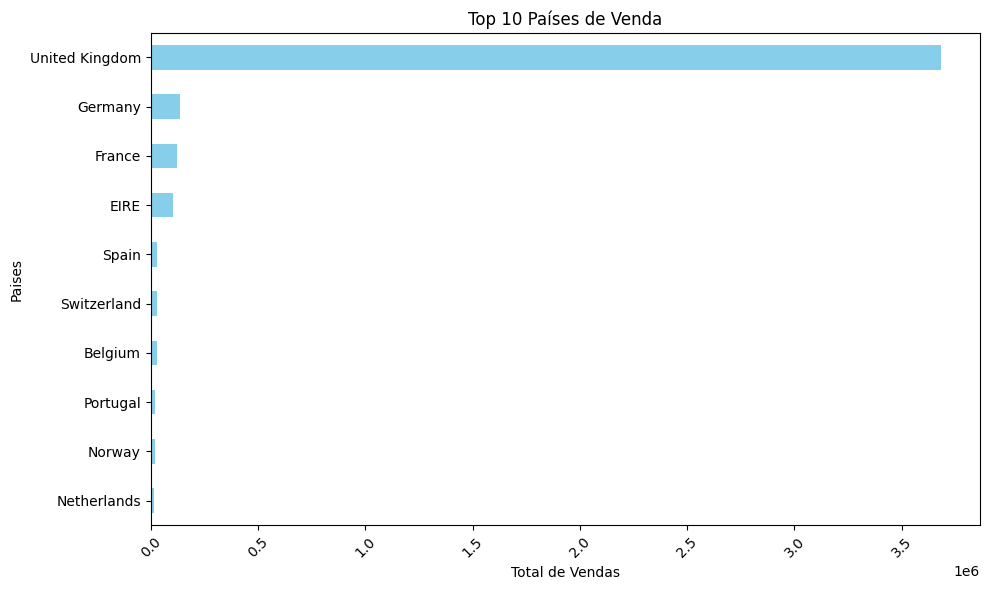

In [ ]:
# Agrupar os dados por país e calcular o total de vendas em cada país
sales_by_country = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Em seguida, selecione apenas os top 10 países
top_10_countries = sales_by_country.head(10).sort_values(ascending=True)

# Agora, plote o gráfico de barras
plt.figure(figsize=(10, 6))
top_10_countries.plot(kind='barh', color='skyblue')
plt.title('Top 10 Países de Venda')
plt.xlabel('Total de Vendas')
plt.ylabel('Paises')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top 10 produtos mais vendidos

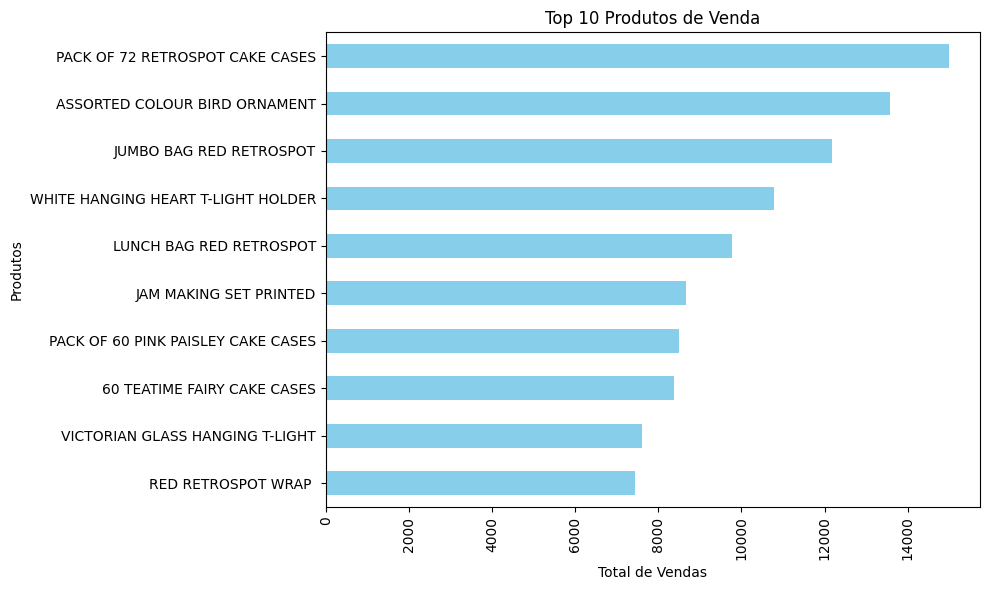

In [ ]:
# Agrupar os dados por país e calcular o total de vendas em cada país
sales_by_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False)

# Em seguida, selecione apenas os top 10 países
top_10_products = sales_by_products.head(10).sort_values(ascending=True)

# Agora, plote o gráfico de barras
plt.figure(figsize=(10, 6))
top_10_products.plot(kind='barh', color='skyblue')
plt.title('Top 10 Produtos de Venda')
plt.xlabel('Total de Vendas')
plt.ylabel('Produtos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Valor de venda total por mês

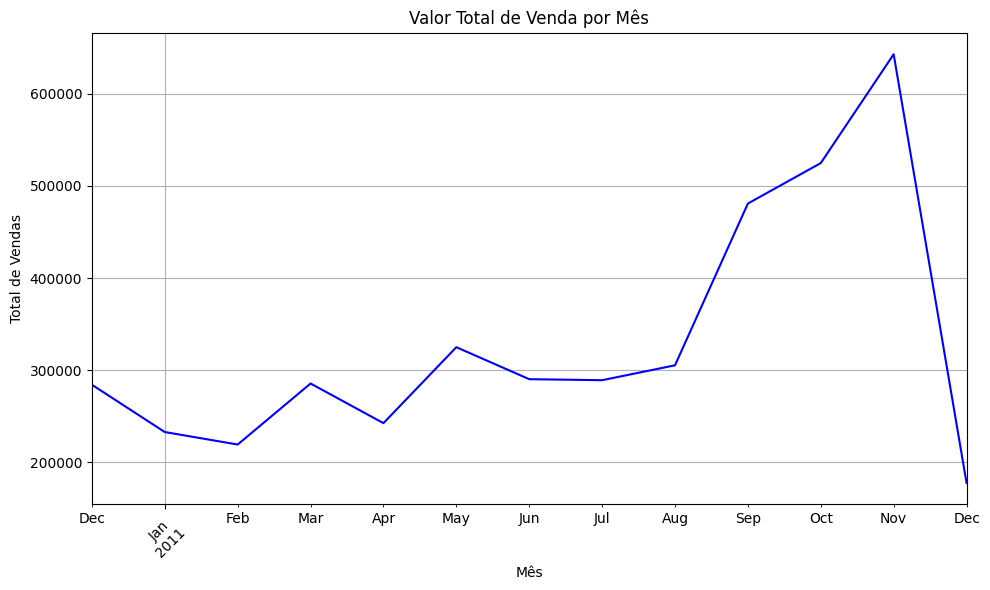

In [ ]:
# Agrupar os dados por mês e calcular o total de vendas em cada mês
df['Month'] = df['InvoiceDate'].dt.to_period('M')
sales_by_month = df.groupby('Month')['TotalPrice'].sum()

# Plotar o gráfico de linha com o valor total de venda por mês
plt.figure(figsize=(10, 6))
sales_by_month.plot(kind='line', color='blue')
plt.title('Valor Total de Venda por Mês')
plt.xlabel('Mês')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Valor de venta total por mês e por país (considerando apenas os top 10)

<Figure size 2000x2000 with 0 Axes>

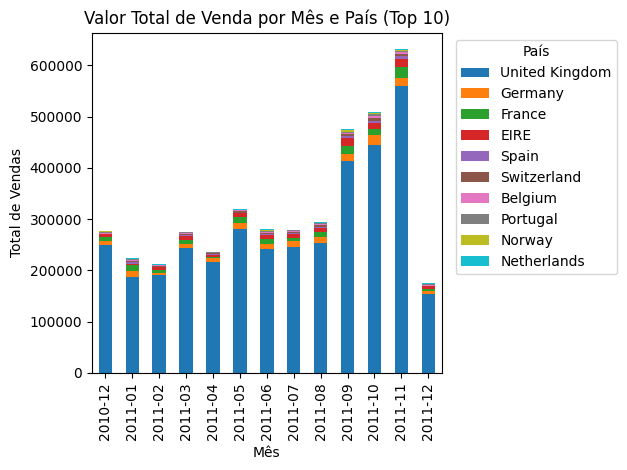

In [ ]:
# Agrupar os dados por mês e país e calcular o total de vendas em cada mês e país
sales_by_month_and_country = df.groupby(['Month', 'Country'])['TotalPrice'].sum().unstack()

# Selecionar apenas os top 10 países
top_10_countries = sales_by_month_and_country.sum().nlargest(10).index
sales_by_month_and_country = sales_by_month_and_country[top_10_countries]

# Plotar o gráfico de barra empilhada com o valor total de venda por mês e por país (top 10)
plt.figure(figsize=(20, 20))
ax = sales_by_month_and_country.plot(kind='bar', stacked=True)
plt.title('Valor Total de Venda por Mês e País (Top 10)')
plt.xlabel('Mês')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=90)

# Colocar a legenda ao lado do gráfico
plt.legend(title='País', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Cálculo do RFM

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333234 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    333234 non-null  object        
 1   StockCode    333234 non-null  object        
 2   Description  333234 non-null  object        
 3   Quantity     333234 non-null  int64         
 4   InvoiceDate  333234 non-null  datetime64[ns]
 5   UnitPrice    333234 non-null  float64       
 6   CustomerID   333234 non-null  object        
 7   Country      333234 non-null  object        
 8   TotalPrice   333234 non-null  float64       
 9   Month        333234 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), period[M](1)
memory usage: 28.0+ MB


In [ ]:
# Passo 1: Agrupar por cliente e InvoiceNo e calcular a data e o preço total do pedido
grouped = df.groupby(['CustomerID', 'InvoiceNo']).agg({
    'InvoiceDate': 'max',
    'TotalPrice': 'sum'
}).reset_index()

# Passo 2: Agrupar novamente por cliente e calcular RFM
last_date = df['InvoiceDate'].max()

rfm = grouped.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (last_date - date.max()).days,  # recency
    'InvoiceNo': 'count',  # frequency
    'TotalPrice': 'mean'   # monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}).reset_index()


rfm

,CustomerID,Recency,Frequency,Monetary
0,12347,1,7,473.532857
1,12348,248,3,30.066667
2,12349,18,1,999.150000
3,12350,309,1,294.400000
4,12352,35,7,161.562857
...,...,...,...,...
4186,18280,277,1,137.000000
4187,18281,180,1,46.920000
4188,18282,7,2,56.565000
4189,18283,3,16,125.164375


In [ ]:
# Gerar um Arquivo CSV com os dados de RFM
rfm.to_csv('e-commerce_rfm.csv', sep=";")